In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv

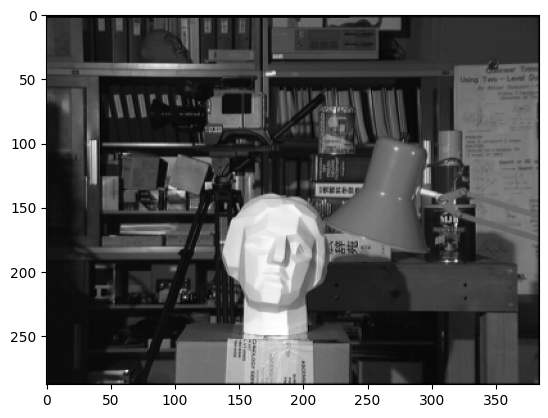

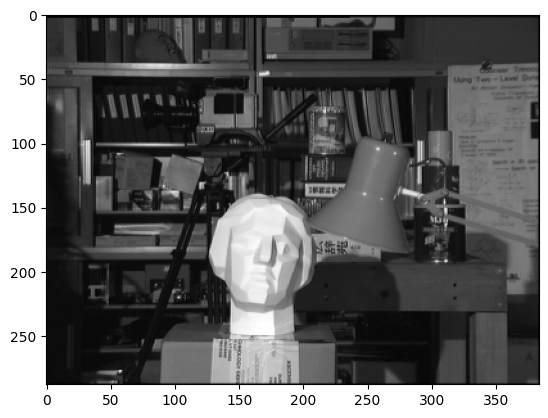

In [2]:
#Reading the images
img1 = cv.imread("scene1.row3.col1.png")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

img2 = cv.imread("scene1.row3.col2.png")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

plt.imshow(img1, cmap='gray')
plt.show()
plt.imshow(img2, cmap='gray')
plt.show()

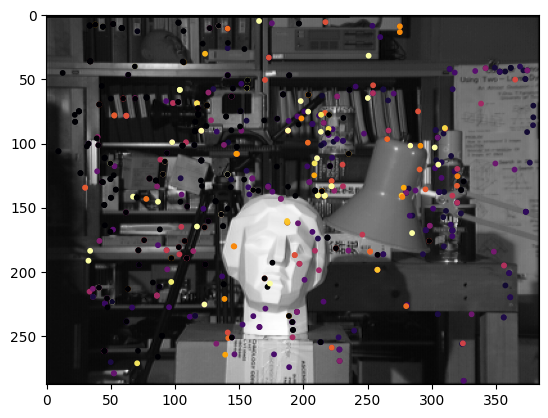

In [15]:
#Task 1
#Finding the features using SIFT
sift = cv.SIFT_create()
KP1, D1 = sift.detectAndCompute(img1, None)
KP2, D2 = sift.detectAndCompute(img2, None)

#Matching features using FLANN
flan = cv.FlannBasedMatcher_create()
matches = flan.knnMatch(D1,D2, 2)

#Estimating Fundemental Matrix
ptsLeft = []
ptsRight = []
for m,n in matches:
    ptsLeft.append(KP1[m.queryIdx].pt)
    ptsRight.append(KP2[n.trainIdx].pt)

ptsLeft = np.float32(ptsLeft)
ptsRight = np.float32(ptsRight)
F, mask = cv.findFundamentalMat(ptsLeft,ptsRight,cv.FM_RANSAC)


#Intrinsics
fx = img1.shape[1]/2
fy = img1.shape[0]/2
cx = fx//1
cy = fy//1

K = np.array([[fx,0,cx], [0,fy,cy], [0,0,1]])

#Computing Essential Matrix
E = np.matmul(np.matmul(np.transpose(K),F),K)

#Getting Pose (R,t) from Essential Matrix
_, R,t, mask = cv.recoverPose(E,ptsLeft,ptsRight, K)

Rt = np.append(R,t, axis = 1)

#Get projection matrices P1 and P2
P1 = np.append(K,[[0],[0],[0]], axis = 1)
P2 = np.matmul(K,Rt)

#Calculating Triangulate Points
pts4d = cv.triangulatePoints(P1, P2, ptsLeft.T, ptsRight.T)
pts3d = pts4d[:3] / pts4d[3]

#Calculating Depth Matrix
disparities = np.linalg.norm(ptsLeft - ptsRight, axis=1) #found from formula
depths = pts3d[2] #second last column gives depth

# Visualizing map
depth_map = np.clip(depths, 0, np.percentile(depths, 95))
depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

plt.imshow(img1, cmap='gray')
sc = plt.scatter(ptsRight[:, 0], ptsRight[:, 1], c=depth_map_normalized, cmap='inferno', s=10)
plt.show()

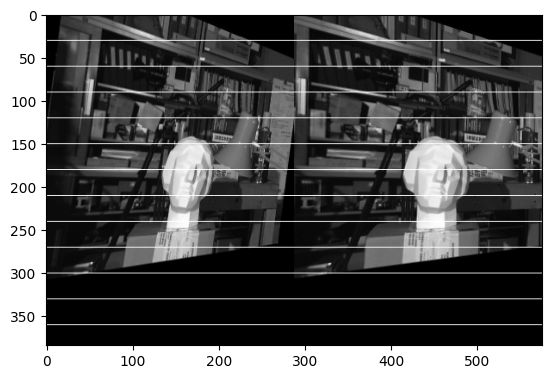

In [9]:
#Task 2
#Rectifying Image and displaying
retval,H1,H2 = cv.stereoRectifyUncalibrated(ptsLeft, ptsRight, F,img1.shape)

img1_rect = cv.warpPerspective(img1, H1, img1.shape)
img2_rect = cv.warpPerspective(img2, H2, img1.shape)

images = np.append(img1_rect, img2_rect, axis = 1)

for row in range(0,images.shape[0],30):
    cv.line(images, (0,row), (images.shape[1],row), (255,255,255), 1) 

plt.imshow(images, cmap = 'grey')
plt.show()